<h1 align=center> Prétraitement et Stratégies de Modélisation </h1>

<h4>L'objectif de ce notebook est d'exploiter la structure du texte (au-delà de la sémantique) et de valider, par comparaison, l'efficacité d'une pondération différenciée des champs (Titre vs Description) par rapport à une fusion simple.</h4>

In [1]:
import sys
sys.path.insert(0, "../src")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

from rakuten_text.cleaning import global_text_cleaner
from rakuten_text.features import add_structural_features, get_meta_feature_columns
from rakuten_text.vectorization import (
    build_tfidf_title,
    build_tfidf_desc,
    build_tfidf_all,
    build_preprocess_split,
    build_preprocess_merged,
)
from rakuten_text.modeling import build_logreg_model, build_pipeline

import warnings
warnings.filterwarnings("ignore")

# Chargement des données brutes
print("Chargement des données brutes...")
X_raw = pd.read_csv("../data/X_train_update.csv", index_col=0)
Y_raw = pd.read_csv("../data/Y_train_CVw08PX.csv", index_col=0)

# Fusion sur productid
df_raw = X_raw.join(Y_raw, how="inner")
print(f"Données fusionnées : {df_raw.shape}")
print(f"Colonnes : {df_raw.columns.tolist()}")

Chargement des données brutes...
Données fusionnées : (84916, 5)
Colonnes : ['designation', 'description', 'productid', 'imageid', 'prdtypecode']


In [2]:
# ============================================================
# EXPÉRIENCE : COMPARAISON DE 6 CONFIGURATIONS DE NETTOYAGE
# ============================================================
# Ce notebook teste systématiquement 6 stratégies de preprocessing
# pour identifier la configuration optimale de nettoyage de texte.

from rakuten_text.cleaning_experiments import (
    get_cleaning_configs,
    build_text_raw_column,
    add_cleaned_variants,
    run_cleaning_experiment,
    print_experiment_analysis,
    plot_experiment_results,
)

# Obtenir les 6 configurations prédéfinies
configs = get_cleaning_configs()

print("✓ Module cleaning_experiments importé")
print(f"✓ {len(configs)} configurations définies:")
for name in configs.keys():
    print(f"  - {name}")

✓ Module cleaning_experiments importé
✓ 6 configurations définies:
  - v0_no_cleaning
  - v1_basic
  - v2_structural
  - v3_boilerplate
  - v4_no_digits
  - v5_no_letters


<h2>Étape 1 : Préparation des Variantes de Texte Nettoyé</h2>

Nous créons d'abord la colonne `text_raw` (concaténation designation + description), puis appliquons les 6 configurations de nettoyage pour obtenir 6 variantes de texte prétraité.

In [3]:
# Étape 1: Créer la colonne text_raw (designation + description)
build_text_raw_column(df_raw)

# Étape 2: Appliquer les 6 configurations de nettoyage
add_cleaned_variants(df_raw, configs, verbose=True)

print("\n✓ Dataset prêt avec 6 variantes de texte nettoyé")
print(f"Shape: {df_raw.shape}")
print(f"\nExemple de colonnes créées:")
for col in ["v0_no_cleaning", "v1_basic", "v3_boilerplate"]:
    if col in df_raw.columns:
        print(f"  - {col}: '{df_raw[col].iloc[0][:80]}...'")


✓ Colonne 'text_raw' créée : 84916 lignes
Création des variantes de texte nettoyé...

  Traitement v0_no_cleaning... ✓ (longueur moyenne: 595 caractères)
  Traitement v1_basic... ✓ (longueur moyenne: 551 caractères)
  Traitement v2_structural... ✓ (longueur moyenne: 549 caractères)
  Traitement v3_boilerplate... ✓ (longueur moyenne: 548 caractères)
  Traitement v4_no_digits... ✓ (longueur moyenne: 544 caractères)
  Traitement v5_no_letters... ✓ (longueur moyenne: 541 caractères)

✓ 6 variantes créées
Colonnes disponibles : ['v0_no_cleaning', 'v1_basic', 'v2_structural', 'v3_boilerplate', 'v4_no_digits', 'v5_no_letters']

✓ Dataset prêt avec 6 variantes de texte nettoyé
Shape: (84916, 12)

Exemple de colonnes créées:
  - v0_no_cleaning: 'Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rose...'
  - v1_basic: 'olivia: personalisiertes notizbuch 150 seiten punktraster ca din a5 rosen-design...'
  - v3_boilerplate: 'olivia: personalisiertes notizbuch 150 seiten p

<h2>Étape 2 : Exécution de l'Expérience de Comparaison</h2>

In [4]:
# ============================================================
# LANCEMENT DE L'EXPÉRIENCE
# ============================================================
# Pour chaque configuration:
#   - Utilise le MÊME split train/validation (random_state=42)
#   - Entraîne TF-IDF + LogisticRegression (mêmes hyperparamètres)
#   - Évalue avec F1 score weighted

results_df = run_cleaning_experiment(
    df=df_raw,
    configs=configs,
    label_column="prdtypecode",
    test_size=0.2,
    random_state=42,
    verbose=True
)

print("\n" + "=" * 80)
print("✓ EXPÉRIENCE TERMINÉE - RÉSULTATS DISPONIBLES")
print("=" * 80)

Création du split train/validation (fixe pour toutes les configs)...
  Train: 67932 échantillons
  Validation: 16984 échantillons

CONFIGURATION : V0_NO_CLEANING
  Entraînement en cours... ✓
  Évaluation sur validation... ✓

  → F1 Score (weighted) : 0.7971

CONFIGURATION : V1_BASIC
  Entraînement en cours... ✓
  Évaluation sur validation... ✓

  → F1 Score (weighted) : 0.7949

CONFIGURATION : V2_STRUCTURAL
  Entraînement en cours... ✓
  Évaluation sur validation... ✓

  → F1 Score (weighted) : 0.7952

CONFIGURATION : V3_BOILERPLATE
  Entraînement en cours... ✓
  Évaluation sur validation... ✓

  → F1 Score (weighted) : 0.7954

CONFIGURATION : V4_NO_DIGITS
  Entraînement en cours... ✓
  Évaluation sur validation... ✓

  → F1 Score (weighted) : 0.7954

CONFIGURATION : V5_NO_LETTERS
  Entraînement en cours... ✓
  Évaluation sur validation... ✓

  → F1 Score (weighted) : 0.7954

✓ ÉVALUATION TERMINÉE POUR TOUTES LES CONFIGURATIONS

✓ EXPÉRIENCE TERMINÉE - RÉSULTATS DISPONIBLES


<h2>Étape 3 : Analyse des Résultats</h2>


TABLEAU COMPARATIF : IMPACT DES STRATÉGIES DE NETTOYAGE

 configuration  f1_weighted  basic_cleaning  structural_merges  boilerplate_removal  remove_single_digit  remove_single_letter
v0_no_cleaning     0.797053           False              False                False                False                 False
v3_boilerplate     0.795441            True               True                 True                False                 False
 v5_no_letters     0.795441            True               True                 True                False                  True
  v4_no_digits     0.795441            True               True                 True                 True                 False
 v2_structural     0.795152            True               True                False                False                 False
      v1_basic     0.794943            True              False                False                False                 False

MEILLEURE CONFIGURATION

Configuration        : v0_n

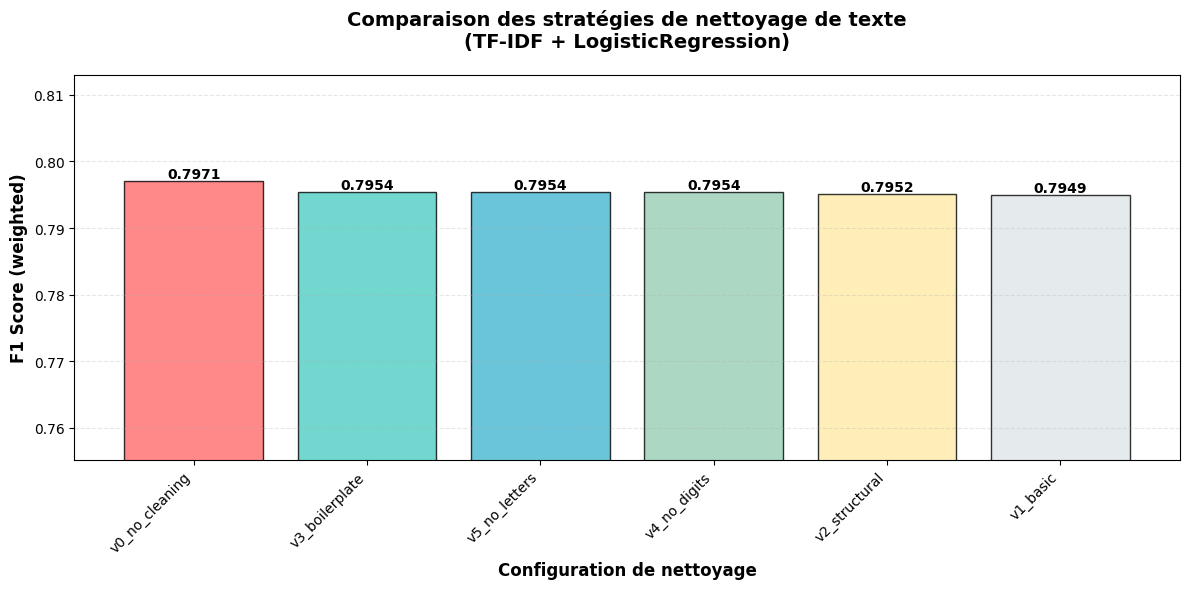

,configuration,f1_weighted,basic_cleaning,structural_merges,boilerplate_removal,remove_single_digit,remove_single_letter
0,v0_no_cleaning,0.797053,False,False,False,False,False
1,v3_boilerplate,0.795441,True,True,True,False,False
2,v5_no_letters,0.795441,True,True,True,False,True
3,v4_no_digits,0.795441,True,True,True,True,False
4,v2_structural,0.795152,True,True,False,False,False
5,v1_basic,0.794943,True,False,False,False,False


In [5]:
# ============================================================
# AFFICHAGE DES RÉSULTATS ET ANALYSE COMPARATIVE
# ============================================================

# Analyse textuelle détaillée
print_experiment_analysis(results_df)

# Visualisation graphique
plot_experiment_results(results_df)

# Retourner le DataFrame pour inspection
results_df

<h2>Notes Méthodologiques</h2>

Les 6 configurations testées sont:
- **v0_no_cleaning**: Baseline minimal (presque aucun preprocessing)
- **v1_basic**: Nettoyage basique (HTML, unicode, lowercase)
- **v2_structural**: v1 + fusions structurelles (dimensions, unités, durées)
- **v3_boilerplate**: v2 + suppression des templates HTML  
- **v4_no_digits**: v3 + suppression des chiffres isolés
- **v5_no_letters**: v3 + suppression des lettres isolées

**Garanties de comparabilité:**
- Même dataset (84916 produits Rakuten)
- Même split train/validation (80/20, stratifié, random_state=42)
- Même modèle (TF-IDF + LogisticRegression, C=2.0, max_iter=1000)
- Même métrique d'évaluation (F1 score weighted)

L'objectif est d'identifier la stratégie de preprocessing optimale pour la classification de produits.

In [6]:
from rakuten_text.cleaning_experiments import run_detailed_ablation_study

df_granular_results = run_detailed_ablation_study(df_raw, random_state=42)

df_granular_results[["configuration", "f1_weighted"]]

1. Generating granular text variants...
  - Processing v1_keep_case (Baseline)...
  - Processing test_keep_html...
  - Processing test_keep_punct...
  - Processing test_skip_unescape...

2. Running benchmark...
Création du split train/validation (fixe pour toutes les configs)...
  Train: 67932 échantillons
  Validation: 16984 échantillons

CONFIGURATION : V1_KEEP_CASE
  Entraînement en cours... ✓
  Évaluation sur validation... ✓

  → F1 Score (weighted) : 0.7949

CONFIGURATION : TEST_KEEP_HTML
  Entraînement en cours... ✓
  Évaluation sur validation... ✓

  → F1 Score (weighted) : 0.7957

CONFIGURATION : TEST_KEEP_PUNCT
  Entraînement en cours... ✓
  Évaluation sur validation... ✓

  → F1 Score (weighted) : 0.7949

CONFIGURATION : TEST_SKIP_UNESCAPE
  Entraînement en cours... ✓
  Évaluation sur validation... ✓

  → F1 Score (weighted) : 0.7946

✓ ÉVALUATION TERMINÉE POUR TOUTES LES CONFIGURATIONS

DETAILED ANALYSIS: WHICH CLEANING STEP IS USEFUL?
Baseline Score (v1_keep_case): 0.794943

,configuration,f1_weighted
0,test_keep_html,0.795674
1,v1_keep_case,0.794943
2,test_keep_punct,0.794943
3,test_skip_unescape,0.794590
